# Detect Faces and Blur Faces
### Complete # TODO

# Requirements

In [3]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# Load Models

In [4]:
# Define the path to the prototxt file using os.path.join for cross-platform compatibility
prototxt_path = os.path.join("models", "deploy.prototxt")

# Define the path to the caffemodel file using os.path.join for cross-platform compatibility
model_path = os.path.join("models", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

# Load the pre-trained Caffe model from the specified files
model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)


# Face Detection and Blur Function

In [5]:
def face_blur(image: np.ndarray):
    # Create a copy of the input image to avoid modifying the original image (critical)
    image = image.copy()
    # Get the height and width of the image
    h, w = image.shape[:2]

    # Define the kernel width and height for Gaussian blurring
    kernel_width = (w // 7) | 1
    kernel_height = (h // 7) | 1

    # Create a blob from the image for input to the neural network
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Set the input for the network
    model.setInput(blob)

    # Perform forward pass to get the output detections
    output = np.squeeze(model.forward())

    # Loop over all detections
    for i in range(0, output.shape[0]):
        # Get the confidence of the detection
        confidence = output[i, 2]

        # Proceed only if the confidence is above the threshold (0.4)
        if confidence > 0.4:
            # Get the bounding box coordinates and scale them to the original image size
            box = output[i, 3:7] * np.array([w, h, w, h])
            start_x, start_y, end_x, end_y = box.astype(int)
            start_x = max(0, start_x)
            start_y = max(0, start_y)
            end_x = min(w-1, end_x)
            end_y = min(h-1, end_y)

            # Extract the face region from the image
            face = image[start_y:end_y, start_x:end_x]

            # Apply Gaussian blur to the face region
            face = cv2.GaussianBlur(face, (kernel_width, kernel_height), 0)

            # Replace the original face region with the blurred face
            image[start_y:end_y, start_x:end_x] = face

    # Return the modified image with blurred faces
    return image


# Result on Image

In [6]:
# Define the path to the image file using os.path.join for cross-platform compatibility
image_path = os.path.join("images", "musk.jpg")

# Read the input image from the specified path
image = cv2.imread(image_path)

# Convert the image from RGB to BGR format (as OpenCV uses BGR by default)
# (Actually, cv2.imread loads as BGR; if you want to display with matplotlib, convert to RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply the face_blur function to the image to blur detected faces
image_face_blur = face_blur(image)


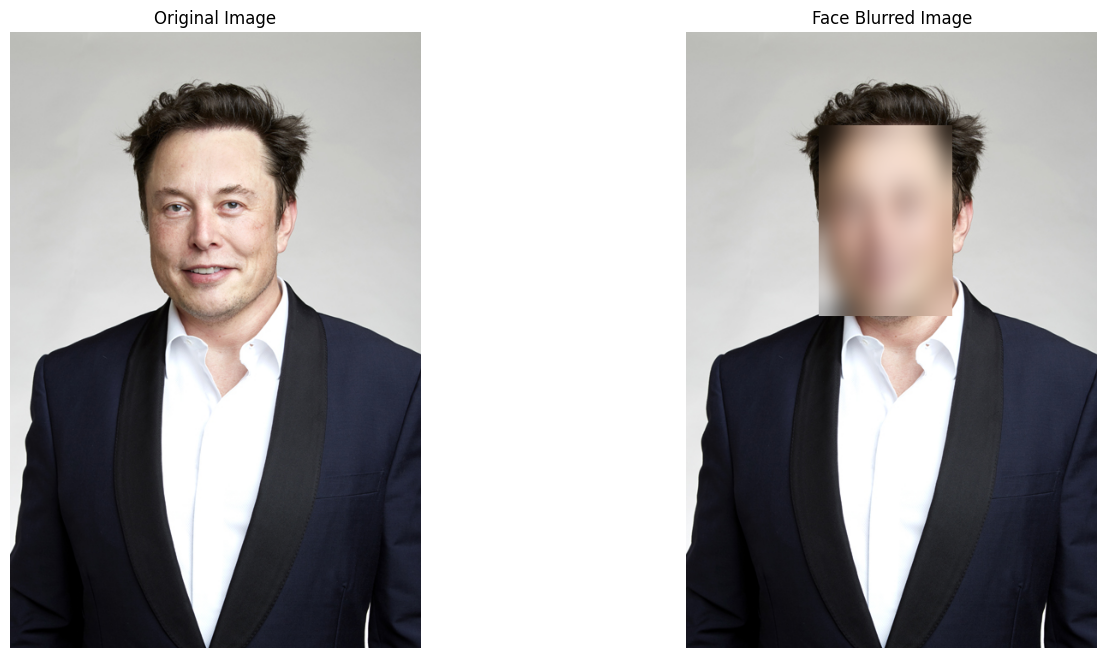

In [7]:
# Create a figure with specified size
plt.figure(figsize=(16, 8))

# Display the original image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Display the blurred face image in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_face_blur, cv2.COLOR_BGR2RGB))
plt.title("Face Blurred Image")
plt.axis("off")
plt.show()


# Result on WebCam Video Stream

In [8]:
def visualize_fps(image, fps: int):
    # Check if the image is grayscale or colored.
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # White color for grayscale images.
    else:
        text_color = (0, 255, 0)  # Green color for colored images.

    row_size = 20 
    left_margin = 24 
    font_size = 1
    font_thickness = 2
    fps_text = "FPS = {:.1f}".format(fps)
    text_location = (left_margin, row_size)
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )
    return image


In [9]:
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
fps = 0

if __name__ == "__main__":
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_WIDTH)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_HEIGHT)

        while True:
            start_time = time.time()  # Record the start time
            ret, frame = cap.read()  # Capture a frame
            if not ret:
                print("Failed to grab frame from camera.")
                break
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize frame
            frame = face_blur(frame)  # Apply face blur
            cv2.imshow("frame", visualize_fps(frame, fps))
            end_time = time.time()  # Record end time
            seconds = end_time - start_time
            fps = 1.0 / seconds if seconds > 0 else 0
            if cv2.waitKey(33) == 27:  # ESC key to break
                break
    except Exception as e:
        print(e)
    finally:
        cv2.destroyAllWindows()
        cap.release()


2025-06-02 02:44:44.423 python[15897:4087006] +[IMKClient subclass]: chose IMKClient_Legacy
2025-06-02 02:44:44.425 python[15897:4087006] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


KeyboardInterrupt: 

In [ ]:
CAMERA_DEVICE_ID = os.path.join("videos", "Jobs_2.mp4")
IMAGE_WIDTH = 1000
IMAGE_HEIGHT = 600
fps = 0
FRAME_RATE = 30
DURATION = 1 / FRAME_RATE

if __name__ == "__main__":
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_WIDTH)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_HEIGHT)

        while True:
            start_time = time.time()
            ret, frame = cap.read()
            if not ret:
                print("End of video or failed to grab frame.")
                break
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            frame = face_blur(frame)
            end_time = time.time()
            seconds = end_time - start_time
            if seconds < DURATION:
                time.sleep(DURATION - seconds)
            seconds = time.time() - start_time
            fps = 1.0 / seconds if seconds > 0 else 0
            cv2.imshow("frame", visualize_fps(frame, fps))
            if cv2.waitKey(33) == 27:
                break
    except Exception as e:
        print(e)
    finally:
        cv2.destroyAllWindows()
        cap.release()

End of video or failed to grab frame.


OpenCV: Couldn't read video stream from file "videos/Jobs_2.mp4"


: 